In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import wrf
import pyart
import pandas as pd
import netCDF4 as nc
import tqdm
import cartopy.crs as ccrs
import cartopy.geodesic as geo


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [2]:
path1 = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_"
times = ["02:30:00","03:00:00","03:30:00","04:00:00"]
wrf_list1 = [nc.Dataset(path1+t) for t in times]

path2 = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_nov23_shortlead/highres_d04_2023-10-16_"
wrf_list2 = [nc.Dataset(path2+t) for t in times]

path3 = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_climo_shortlead/highres_d04_2023-10-16_"
wrf_list3 = [nc.Dataset(path3+t) for t in times]

In [3]:
def wind_speed(wrf_list):
    wspd_wdir10 = wrf.getvar(wrf_list,"wspd_wdir10",timeidx=wrf.ALL_TIMES)
    uvmet10 = wrf.getvar(wrf_list,"uvmet10",timeidx=wrf.ALL_TIMES)
    lats, lons = wrf.latlon_coords(wspd_wdir10)
    return wspd_wdir10, uvmet10, lons, lats

wspd_wdir101, uvmet101, wrf_lons1, wrf_lats1 = wind_speed(wrf_list1)
wspd_wdir101 = wspd_wdir101.persist()
#theta_e1 = wrf.getvar(wrf_list1,"theta_e",timeidx=wrf.ALL_TIMES).isel(bottom_top=0).persist()

wspd_wdir102, uvmet102, wrf_lons2, wrf_lats2 = wind_speed(wrf_list2)
wspd_wdir102 = wspd_wdir102.persist()
#theta_e2 = wrf.getvar(wrf_list2,"theta_e",timeidx=wrf.ALL_TIMES).isel(bottom_top=0).persist()

wspd_wdir103, uvmet103, wrf_lons3, wrf_lats3 = wind_speed(wrf_list3)
wspd_wdir103 = wspd_wdir103.persist()

In [4]:
wrf_lons1.values.shape

(681, 681)

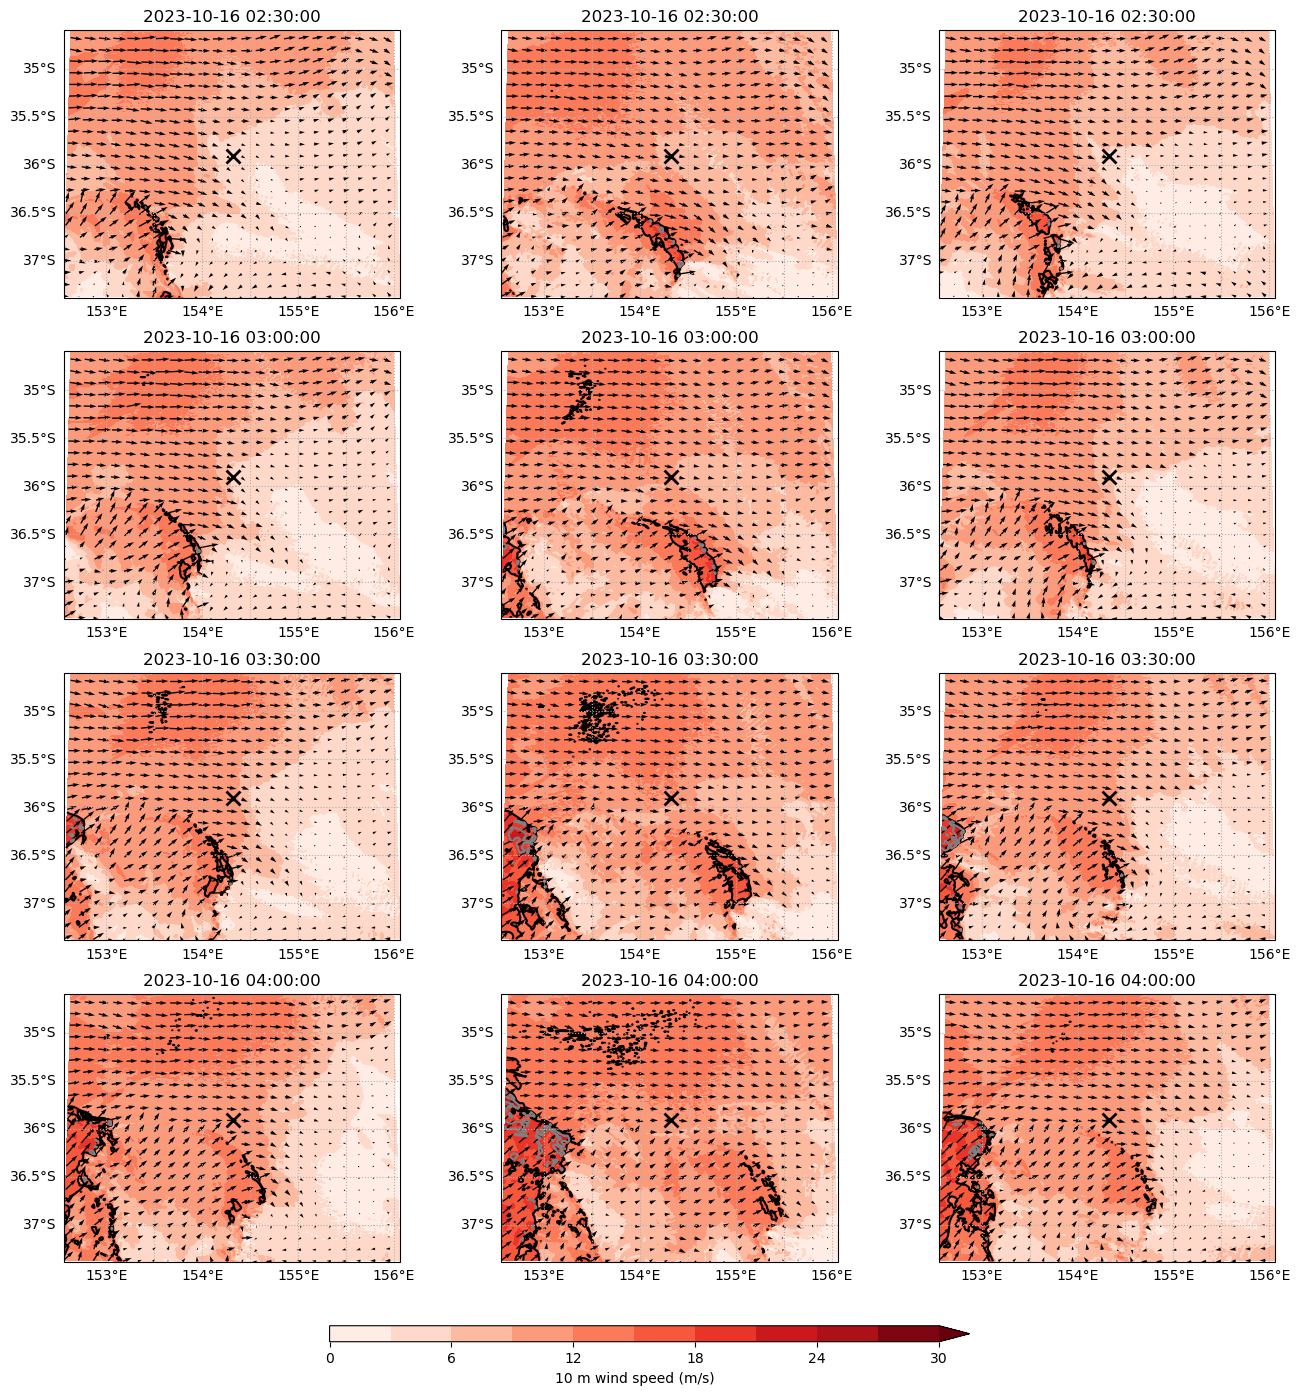

In [5]:
def add_lines(ax):
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    
fig = plt.figure(figsize=(16,16)) 
    
cnt=1
step=30
for t in [0,1,2,3]:#tqdm.tqdm(range(len(wrf_list1))):
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons1.values, wrf_lats1.values, wspd_wdir101.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds"), levels=np.linspace(0,30,11), extend="max")
    ax.contour(wrf_lons1.values, wrf_lats1.values, wspd_wdir101.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])
    ax.quiver(wrf_lons1.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values,
              wrf_lats1.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values, 
               uvmet101.isel(u_v=0,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),
               uvmet101.isel(u_v=1,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),width=0.004)
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir101.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    if t == 2:
        cax = plt.axes([0.3,0.06,0.4,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")
        cb.set_label("10 m wind speed (m/s)")        
    cnt = cnt+1
    
    
    #NOTE: Bottom model level is around 25 m AGL
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons2.values, wrf_lats2.values, wspd_wdir102.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds"), levels=np.linspace(0,30,11), extend="max")
    ax.contour(wrf_lons2.values, wrf_lats2.values, wspd_wdir102.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir102.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    ax.quiver(wrf_lons2.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values,
          wrf_lats2.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values, 
           uvmet102.isel(u_v=0,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),
           uvmet102.isel(u_v=1,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),width=0.004)
    cnt = cnt+1
    
    #NOTE: Bottom model level is around 25 m AGL
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons3.values, wrf_lats3.values, wspd_wdir103.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds"), levels=np.linspace(0,30,11), extend="max")
    ax.contour(wrf_lons3.values, wrf_lats3.values, wspd_wdir103.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir103.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    ax.quiver(wrf_lons3.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values,
          wrf_lats3.isel(west_east=slice(0,-1,step),south_north=slice(0,-1,step)).values, 
           uvmet103.isel(u_v=0,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),
           uvmet103.isel(u_v=1,Time=t,west_east=slice(0,-1,step),south_north=slice(0,-1,step)),width=0.004)
    cnt = cnt+1    

In [6]:
# fig = plt.figure(figsize=(10,13)) 
    
# cnt=1
# for t in [0,1,2]:#tqdm.tqdm(range(len(wrf_list1))):
#     ax = plt.subplot(3,2,cnt,projection=ccrs.PlateCarree())
#     c=ax.contourf(wrf_lons1.values, wrf_lats1.values, theta_e1.isel(Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Blues_r"), levels=np.linspace(295,325,11), extend="both")
#     ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
#     plt.title(pd.to_datetime(wspd_wdir101.Time.isel(Time=t).values))
#     add_lines(ax)
#     cnt=cnt+1
    
#     ax = plt.subplot(3,2,cnt,projection=ccrs.PlateCarree())
#     c=ax.contourf(wrf_lons2.values, wrf_lats2.values, theta_e2.isel(Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Blues_r"), levels=np.linspace(295,325,11), extend="both")
#     ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
#     plt.title(pd.to_datetime(wspd_wdir102.Time.isel(Time=t).values))
#     add_lines(ax)
#     if t == 2:
#         cax = plt.axes([0.57,0.06,0.3,0.01])
#         cb = plt.colorbar(c,cax,orientation="horizontal")        
#         cb.set_label("Near-surface equivalent potential temperature (K)")
#     cnt=cnt+1

In [7]:
wrf_refl1 = wrf.getvar(wrf_list1,"mdbz",timeidx=wrf.ALL_TIMES).persist()
wrf_refl2 = wrf.getvar(wrf_list2,"mdbz",timeidx=wrf.ALL_TIMES).persist()
wrf_refl3 = wrf.getvar(wrf_list3,"mdbz",timeidx=wrf.ALL_TIMES).persist()


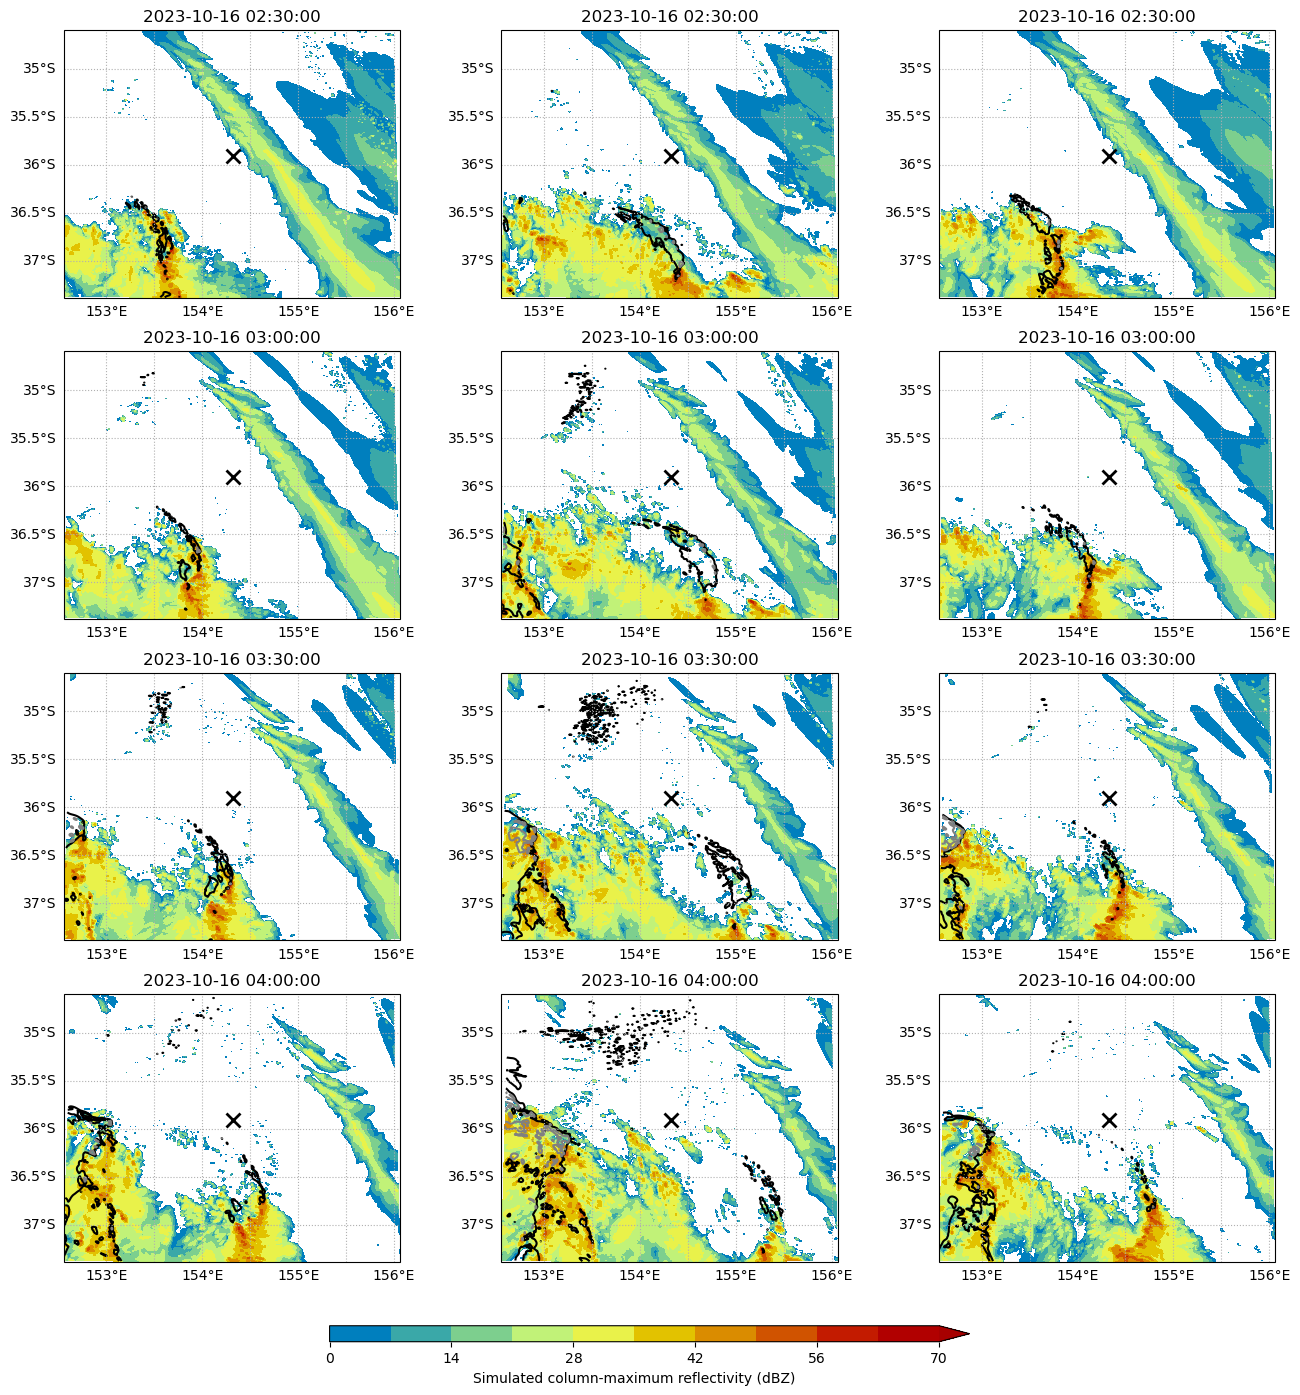

In [8]:
fig = plt.figure(figsize=(16,16)) 
    
cnt=1
for t in [0,1,2,3]:#tqdm.tqdm(range(len(wrf_list))):
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons1.values, wrf_lats1.values, wrf_refl1.isel(Time=t), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11), extend="max")
    ax.contour(wrf_lons1.values, wrf_lats1.values, wspd_wdir101.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])    
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir101.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    if t == 2:
        cax = plt.axes([0.3,0.06,0.4,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")
        cb.set_label("Simulated column-maximum reflectivity (dBZ)") 
    cnt = cnt+1
    
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons2.values, wrf_lats2.values, wrf_refl2.isel(Time=t), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11), extend="max")
    ax.contour(wrf_lons2.values, wrf_lats2.values, wspd_wdir102.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])    
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir102.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    cnt=cnt+1
    
    ax = plt.subplot(4,3,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons3.values, wrf_lats3.values, wrf_refl3.isel(Time=t), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11), extend="max")
    ax.contour(wrf_lons3.values, wrf_lats3.values, wspd_wdir103.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])    
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir103.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    cnt=cnt+1    

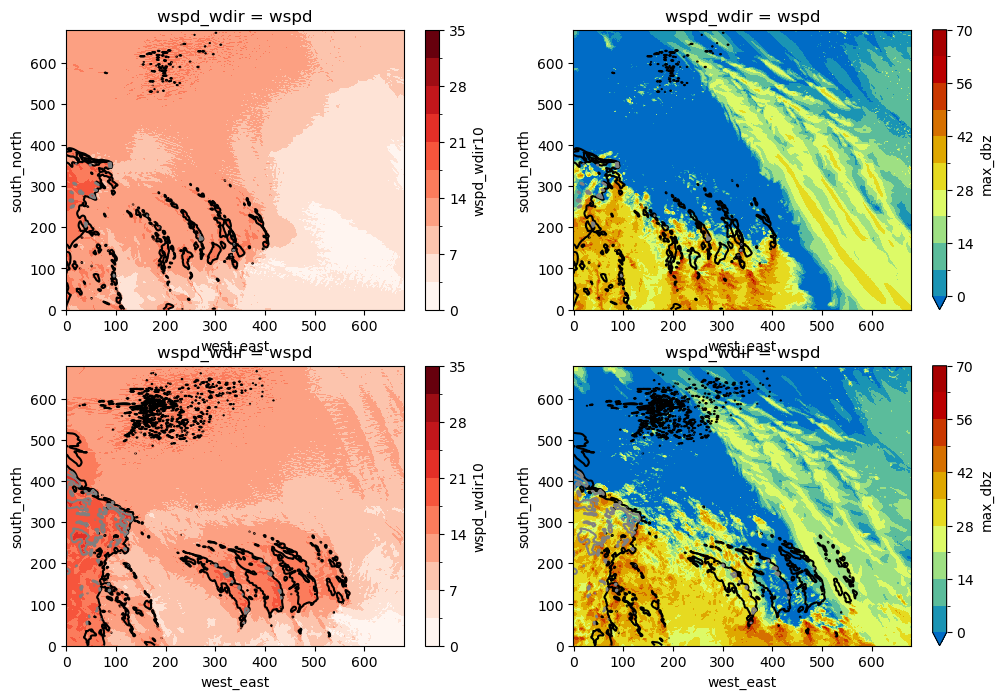

In [32]:
plt.figure(figsize=[12,8])

plt.subplot(2,2,1)
wspd_wdir101.isel(wspd_wdir=0).max("Time").plot(cmap="Reds",levels=np.linspace(0,35,11))
xr.plot.contour(wspd_wdir101.isel(wspd_wdir=0).max("Time"),levels=[15,20],colors=["k","grey"])

plt.subplot(2,2,3)
wspd_wdir102.isel(wspd_wdir=0).max("Time").plot(cmap="Reds",levels=np.linspace(0,35,11))
xr.plot.contour(wspd_wdir102.isel(wspd_wdir=0).max("Time"),levels=[15,20],colors=["k","grey"])

plt.subplot(2,2,2)
wrf_refl1.max("Time").plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,70,11))
xr.plot.contour(wspd_wdir101.isel(wspd_wdir=0).max("Time"),levels=[15,20],colors=["k","grey"])

plt.subplot(2,2,4)
wrf_refl2.max("Time").plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.linspace(0,70,11))
xr.plot.contour(wspd_wdir102.isel(wspd_wdir=0).max("Time"),levels=[15,20],colors=["k","grey"])

In [23]:
def get_wrf_wind(wrf_list,bottom_top,t):
    #bottom_top = 11 for ~1000 m AGL, 7 for ~500 m AGL
    u = wrf.getvar(wrf_list,"U",timeidx=t).isel(bottom_top=bottom_top).persist()
    v = wrf.getvar(wrf_list,"V",timeidx=t).isel(bottom_top=bottom_top).persist()
    wspd_wdir = wrf.getvar(wrf_list,"wspd_wdir",timeidx=t).isel(bottom_top=bottom_top).persist()
    return u,v,wspd_wdir



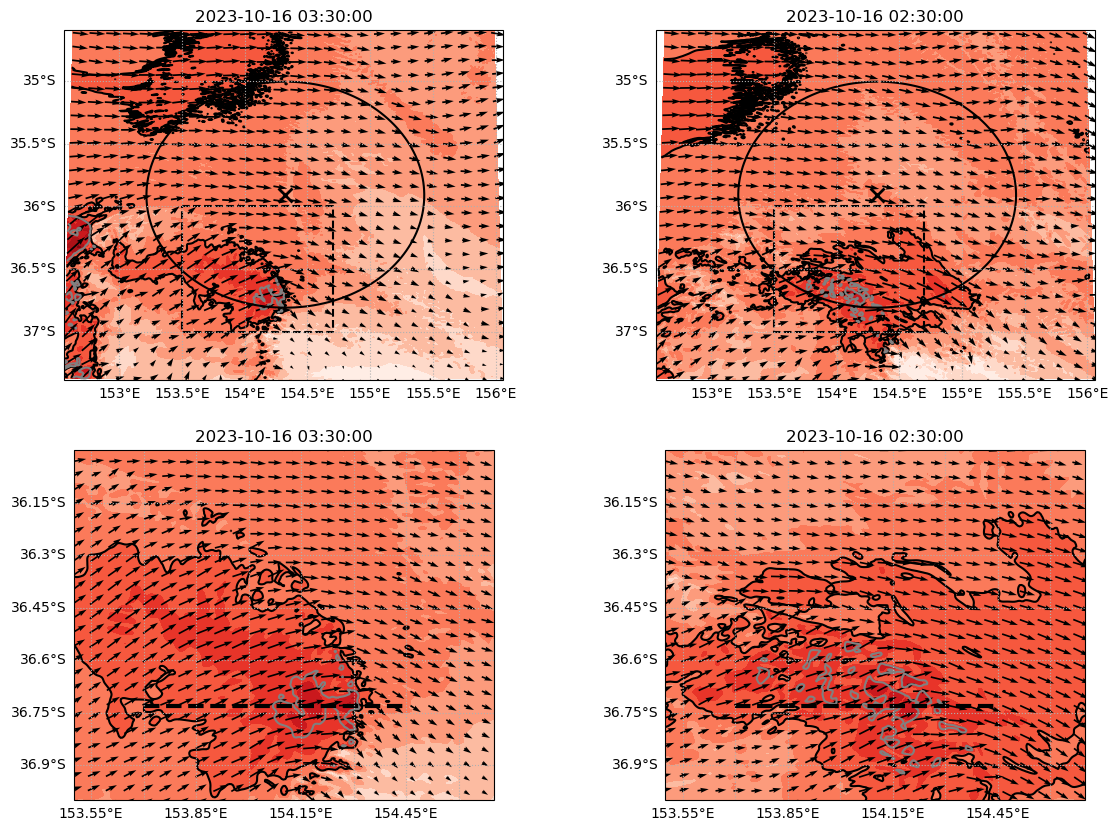

In [29]:
#Get WRF wind and direction at model level z
t=0
z=7
circle = geo.Geodesic().circle(154.3239, -35.9070, 100*1000)

path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_"
times = ["03:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]
wrf_u,wrf_v,wspd_wdir = get_wrf_wind(wrf_list,z,t)

plt.figure(figsize=[14,10])

#Set plotting bounds and WRF quiver step
lats = [-37,-36]
lons = [153.5,154.7]

#Plot WRF for whole d04
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons1.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons1.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=27
xinds = wrf_lons1.west_east.shape[0]
yinds = wrf_lons1.south_north.shape[0]
ax.quiver(wrf_lons1.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats1.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
ax.plot([lons[0],lons[1],lons[1],lons[0],lons[0]], [lats[1],lats[1],lats[0],lats[0],lats[1]],color="k",ls="--")
ax.plot(circle[:,0],circle[:,1],color="k")

#Plot for just the bounds above
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons1.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons1.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=10
xinds = wrf_lons1.west_east.shape[0]
yinds = wrf_lons1.south_north.shape[0]
ax.quiver(wrf_lons1.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats1.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
lons1 = [153.7,154.45]
lats1 = [-36.73,-36.73]
ax.plot(lons1, lats1, color="k",ls="--",lw=3)

#Now plot the other WRF experiment

#Get WRF wind and direction at model level z
t=0
z=7
circle = geo.Geodesic().circle(154.3239, -35.9070, 100*1000)

path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231016_20231016_ramssa_nov23_shortlead/highres_d04_2023-10-16_"
times = ["02:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]
wrf_u,wrf_v,wspd_wdir = get_wrf_wind(wrf_list,z,t)

#Set plotting bounds and WRF quiver step
lats = [-37,-36]
lons = [153.5,154.7]

#Plot WRF for whole d04
ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons2.values, wrf_lats2.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons2.values, wrf_lats2.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=27
xinds = wrf_lons2.west_east.shape[0]
yinds = wrf_lons2.south_north.shape[0]
ax.quiver(wrf_lons2.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats2.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
ax.plot([lons[0],lons[1],lons[1],lons[0],lons[0]], [lats[1],lats[1],lats[0],lats[0],lats[1]],color="k",ls="--")
ax.plot(circle[:,0],circle[:,1],color="k")

#Plot for just the bounds above
ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons2.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons2.values, wrf_lats1.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=10
xinds = wrf_lons2.west_east.shape[0]
yinds = wrf_lons2.south_north.shape[0]
ax.quiver(wrf_lons2.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats2.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
lons1 = [153.7,154.45]
lats1 = [-36.73,-36.73]
ax.plot(lons1, lats1, color="k",ls="--",lw=3)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but 

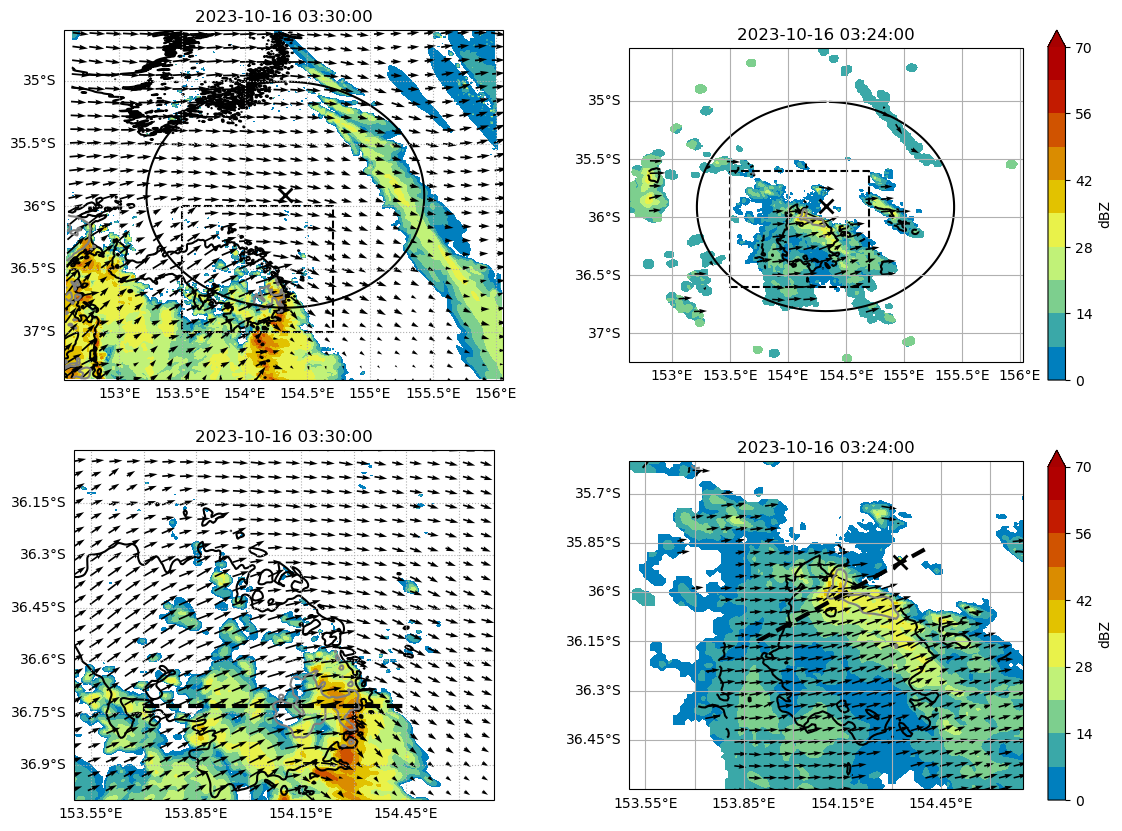

In [46]:
#Get WRF wind and direction at model level z
t=0
z=7

path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_"
times = ["03:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]
wrf_u,wrf_v,wspd_wdir = get_wrf_wind(wrf_list,z,t)

plt.figure(figsize=[14,10])

#Set plotting bounds and WRF quiver step
lats = [-37,-36]
lons = [153.5,154.7]

#Plot WRF for whole d04
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#Refl
c=ax.contourf(wrf_lons.values, wrf_lats.values, wrf_refl.isel(Time=1), transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=27
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
ax.plot([lons[0],lons[1],lons[1],lons[0],lons[0]], [lats[1],lats[1],lats[0],lats[0],lats[1]],color="k",ls="--")
ax.plot(circle[:,0],circle[:,1],color="k")

#Plot for just the bounds above
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
#Refl
c=ax.contourf(wrf_lons.values, wrf_lats.values, wrf_refl.isel(Time=1), transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=10
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400,width=0.004)
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
lons1 = [153.7,154.45]
lats1 = [-36.73,-36.73]
ax.plot(lons1, lats1, color="k",ls="--",lw=3)

#Now plot SWIRL

t="0324"
grid_t="20231016_032400"
title="2023-10-16 03:24:00"
z=500

lons = [153.5,154.7]
lats = [-36.6,-35.6]

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=12)
grid,obs_lon,obs_lat = read_grid(grid_t)
c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=400,width=0.004)
cb=plt.colorbar(c)
cb.set_label("dBZ")
ax.gridlines(draw_labels=["bottom","left"])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
ax.plot([lons[0],lons[1],lons[1],lons[0],lons[0]], [lats[1],lats[1],lats[0],lats[0],lats[1]],color="k",ls="--")
ax.plot(circle[:,0],circle[:,1],color="k")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=4)
c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=400,width=0.004)
cb=plt.colorbar(c)
cb.set_label("dBZ")
ax.gridlines(draw_labels=["bottom","left"])
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
transect_lon1 = [153.89,154.4]
transect_lat1 = [-36.15,-35.87]
ax.plot(transect_lon1,transect_lat1,color="k",lw=3, ls="--")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/plan_view/refl_500m.jpeg",dpi=400,bbox_inches="tight")

In [17]:
h = wrf.getvar(wrf_list,"height_agl")

In [20]:
h.isel(bottom_top=19)

<xarray.DataArray 'height_agl' (south_north: 681, west_east: 681)>
array([[2612.7878, 2612.766 , 2612.7732, ..., 2634.8684, 2634.9438,
        2635.0059],
       [2612.7854, 2612.7651, 2612.7634, ..., 2634.9133, 2635.027 ,
        2635.0864],
       [2612.794 , 2612.774 , 2612.7842, ..., 2634.9646, 2635.094 ,
        2635.162 ],
       ...,
       [2651.3682, 2651.3933, 2651.4233, ..., 2677.6997, 2677.7224,
        2677.7334],
       [2651.5356, 2651.556 , 2651.575 , ..., 2677.6777, 2677.7048,
        2677.7334],
       [2651.7148, 2651.7266, 2651.752 , ..., 2677.6448, 2677.676 ,
        2677.7112]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 152.6 152.6 152.6 ... 156.0 156.0
    XLAT     (south_north, west_east) float32 -37.37 -37.37 ... -34.59 -34.59
    XTIME    float32 1.53e+03
    Time     datetime64[ns] 2023-10-16T04:30:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  model height - [AGL] (mass grid)
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=154.3000030517578, moad_cen_lat=...